# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [1]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

# plt.rcParams['figure.figsize'] = (10, 6)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)
* Spectral Clustering

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin
import queue
import collections

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    
    def __init__(self, **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        
        self.epsilon = kwargs['epsilon']
        self.minPoint = kwargs['minPoint']
        
        return
    
    def neighbor_points(self, data: np.ndarray, pointId: int, radius: float) -> list:
        '''
        Custom function to find all neigbor points in a radius for DBScan Algorithm
        '''
        points = []
        for i in range(len(data)):
            #Euclidian distance using L2 Norm
            if np.linalg.norm(data[i] - data[pointId]) <= radius:
                points.append(i)
        return points
    
        
    def fit(self, data: np.ndarray):
        """
        DBScan Algorithm Fit
        Use data values to cluster using the parameters of Epsilon and MinPoints.
        """
        #Define label for differnt point group
        UNASSIGNED = 0
        core=-1
        edge=-2
    
        #initialize all the pointLabels to unassigned
        pointLabel = [UNASSIGNED] * len(data)
        pointCount = []

        #initialize the lsits for core and non-core points
        corePoint = []
        noncorePoint = []

        #Find all the neighbors for any point
        for i in range(len(data)):
            pointCount.append(self.neighbor_points(data, i, self.epsilon))

        #Find all core point, edge point and noise in the data
        for i in range(len(pointCount)):
            if len(pointCount[i]) >= self.minPoint:
                pointLabel[i] = core
                corePoint.append(i) #keep the indices IDs
            else:
                noncorePoint.append(i)

        for i in noncorePoint:
            for j in pointCount[i]:
                if j in corePoint:
                    pointlabel[i]=edge

                    break

        #Assign points to clusters, and use Queue to put all neighbor core points into a queue, and 
        #find neighbor's neighbor
        cluster = 1 #initialize a cluster
 
        for i in range(len(pointLabel)):
            q = queue.Queue()
            if pointLabel[i] == core:
                pointLabel[i] = cluster

                for j in pointCount[i]:
                    if pointLabel[j] == core:
                        q.put(j)
                        pointLabel[j] = cluster
                    elif pointLabel[j] == edge:
                        pointLabel[j] = cluster

                #Assign the points to a cluster, and stop when all the points in the Queue have been checked
                while not q.empty():
                    neighbors = pointCount[q.get()]
                    for x in neighbors:
                        if pointLabel[x] == core:
                            pointLabel[x] = cluster
                            q.put(x)

                        if pointLabel[x] == edge:
                            pointLabel[x] = cluster

                cluster += 1 # Move to the next cluster         

        return pointLabel, cluster
    
    def predict_plot(self, data, clusters, cluster_number):
        """
        Fit and plot DBScan model on a sample data, provided pointlable and cluster
        """
        num_points = len(data)
        scatter_colors = ['black', 'purple', 'brown', 'green', 'orange', 'red', 'yellow']
        for i in range(cluster_number):
            if (i==0):
                #Plot all noise point as blue
                color='blue'
            else:
                color = scatter_colors[i % len(scatter_colors)]
            x1 = [];  y1 = []
            for j in range(num_points):
                if clusters[j] == i:
                    x1.append(data[j, 0])
                    y1.append(data[j, 1])
            plt.scatter(x1, y1, c=color, alpha=1)
        
        
    


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

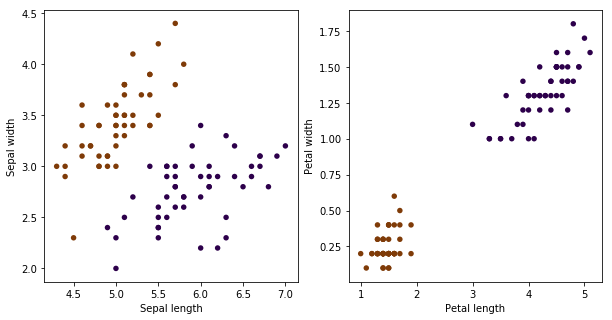

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Case: Epsilon = 0.30, MinPoints = 2
Number of clusters: 6
Overall classes:
Counter({1: 45, 4: 41, 5: 5, 6: 4, 2: 2, 3: 2, 0: 1})
Number of outliers: 1


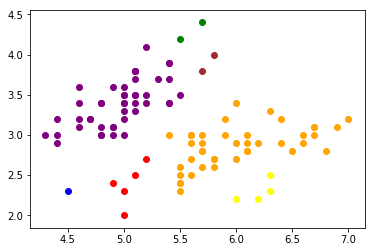



Case: Epsilon = 0.30, MinPoints = 3
Number of clusters: 4
Overall classes:
Counter({1: 45, 2: 38, 0: 12, 3: 3, 4: 2})
Number of outliers: 12


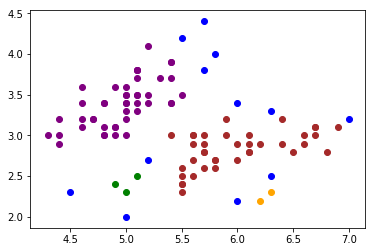



Case: Epsilon = 0.31, MinPoints = 2
Number of clusters: 6
Overall classes:
Counter({1: 45, 4: 41, 5: 5, 6: 4, 2: 2, 3: 2, 0: 1})
Number of outliers: 1


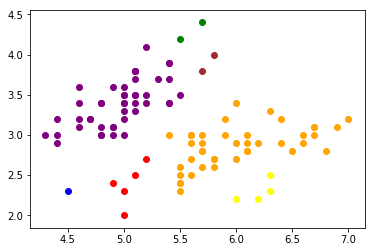



Case: Epsilon = 0.31, MinPoints = 3
Number of clusters: 4
Overall classes:
Counter({1: 45, 2: 38, 0: 12, 3: 3, 4: 2})
Number of outliers: 12


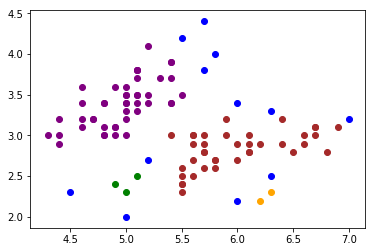



Case: Epsilon = 0.32, MinPoints = 2
Number of clusters: 3
Overall classes:
Counter({1: 49, 2: 46, 3: 4, 0: 1})
Number of outliers: 1


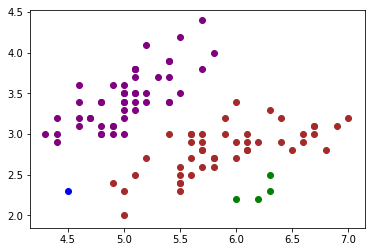



Case: Epsilon = 0.32, MinPoints = 3
Number of clusters: 3
Overall classes:
Counter({1: 47, 2: 45, 0: 4, 3: 4})
Number of outliers: 4


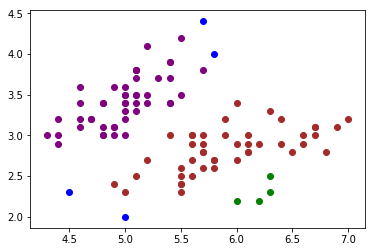



Case: Epsilon = 0.33, MinPoints = 2
Number of clusters: 3
Overall classes:
Counter({1: 49, 2: 46, 3: 4, 0: 1})
Number of outliers: 1


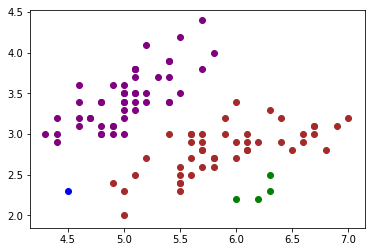



Case: Epsilon = 0.33, MinPoints = 3
Number of clusters: 3
Overall classes:
Counter({1: 47, 2: 45, 0: 4, 3: 4})
Number of outliers: 4


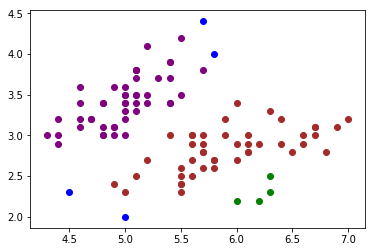



Case: Epsilon = 0.34, MinPoints = 2
Number of clusters: 3
Overall classes:
Counter({1: 49, 2: 46, 3: 4, 0: 1})
Number of outliers: 1


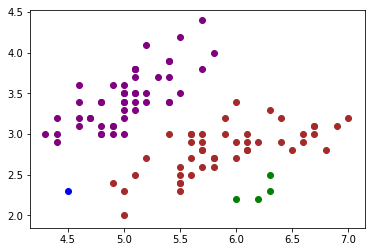



Case: Epsilon = 0.34, MinPoints = 3
Number of clusters: 3
Overall classes:
Counter({1: 47, 2: 45, 0: 4, 3: 4})
Number of outliers: 4


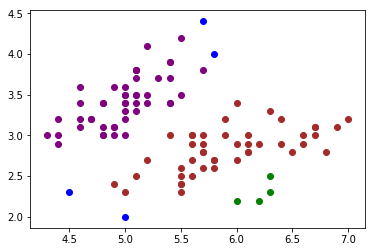



Case: Epsilon = 0.35, MinPoints = 2
Number of clusters: 3
Overall classes:
Counter({1: 49, 2: 46, 3: 4, 0: 1})
Number of outliers: 1


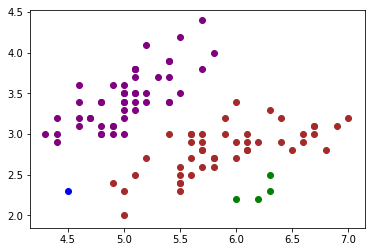



Case: Epsilon = 0.35, MinPoints = 3
Number of clusters: 3
Overall classes:
Counter({1: 47, 2: 45, 0: 4, 3: 4})
Number of outliers: 4


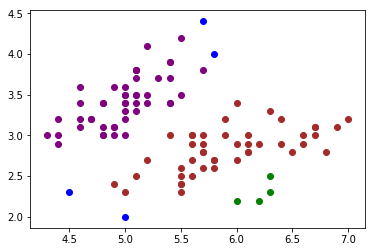



Case: Epsilon = 0.36, MinPoints = 2
Number of clusters: 3
Overall classes:
Counter({1: 49, 2: 46, 3: 4, 0: 1})
Number of outliers: 1


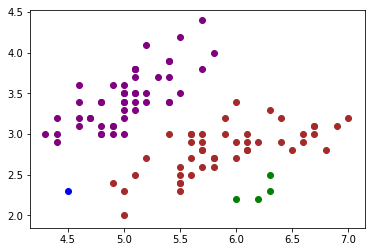



Case: Epsilon = 0.36, MinPoints = 3
Number of clusters: 3
Overall classes:
Counter({1: 47, 2: 45, 0: 4, 3: 4})
Number of outliers: 4


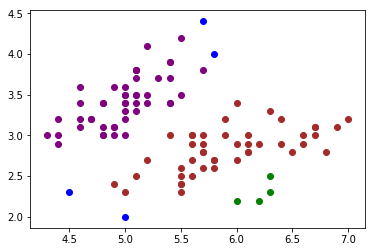



Case: Epsilon = 0.37, MinPoints = 2
Number of clusters: 1
Overall classes:
Counter({1: 99, 0: 1})
Number of outliers: 1


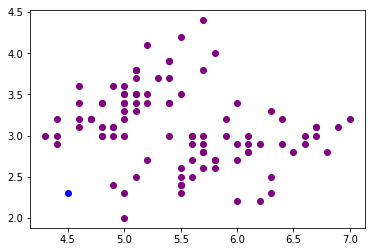



Case: Epsilon = 0.37, MinPoints = 3
Number of clusters: 1
Overall classes:
Counter({1: 97, 0: 3})
Number of outliers: 3


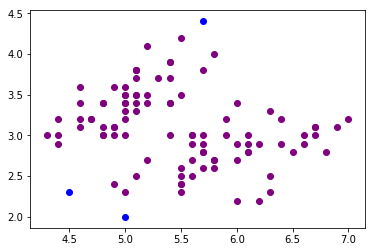



Case: Epsilon = 0.38, MinPoints = 2
Number of clusters: 1
Overall classes:
Counter({1: 99, 0: 1})
Number of outliers: 1


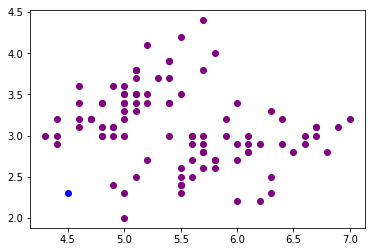



Case: Epsilon = 0.38, MinPoints = 3
Number of clusters: 1
Overall classes:
Counter({1: 97, 0: 3})
Number of outliers: 3


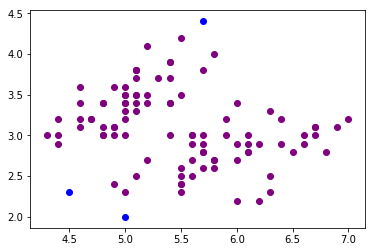



Case: Epsilon = 0.39, MinPoints = 2
Number of clusters: 1
Overall classes:
Counter({1: 99, 0: 1})
Number of outliers: 1


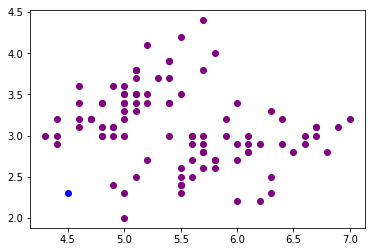



Case: Epsilon = 0.39, MinPoints = 3
Number of clusters: 1
Overall classes:
Counter({1: 97, 0: 3})
Number of outliers: 3


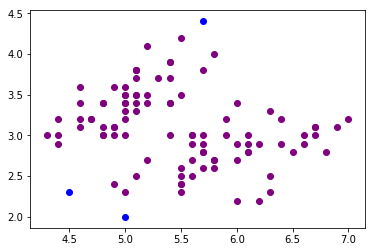



Case: Epsilon = 0.40, MinPoints = 2
Number of clusters: 1
Overall classes:
Counter({1: 99, 0: 1})
Number of outliers: 1


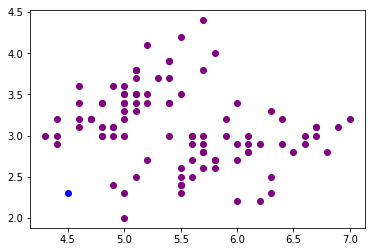



Case: Epsilon = 0.40, MinPoints = 3
Number of clusters: 1
Overall classes:
Counter({1: 97, 0: 3})
Number of outliers: 3


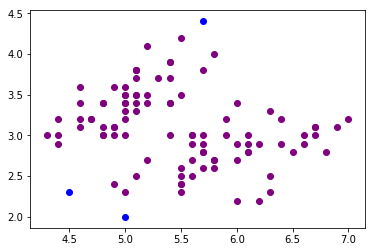

In [4]:
train = x_iris[:100,:2]
# After executing for multiple epsilons and min points foud the following range to be optimal to show the process
epss = np.arange(0.3, 0.4, 0.01)
minPoints = np.arange(2,4)



for eps in epss:
    for minPoint in minPoints:
        print('Case: Epsilon = {epsilon:.2f}, MinPoints = {minPoint}'.format(epsilon=eps, minPoint=minPoint))
        db_scan = Clustering(epsilon = eps, minPoint = minPoint)
        pointlabel,cluster = db_scan.fit(train)
        print('Number of clusters: {cl}'.format(cl=cluster-1))
        counter = collections.Counter(pointlabel)
        print('Overall classes:')
        print(counter)
        outliers = pointlabel.count(0)
        print('Number of outliers: {outliers}'.format(outliers=outliers))
        db_scan.predict_plot(train, pointlabel, cluster)
        plt.show()
        print('\n')
        
#After analyzing the results, the DBScan algorithm have not had a case with 2 classes the best case was with 
#3 classes and outliers. Choosing Epsilon = 0.33, and MinPoints = 2 gives the best result having the following 
#parameters

In [5]:
# Case: Epsilon = 0.33, MinPoints = 2 
# Number of clusters: 3
# Overall classes:
# Counter({1: 49, 2: 46, 3: 4, 0: 1})
# Number of outliers: 1

Case: Epsilon = 0.40, MinPoints = 3
Number of clusters: 3
Overall classes:
Counter({1: 49, 2: 46, 3: 4, 0: 1})
Number of outliers: 1


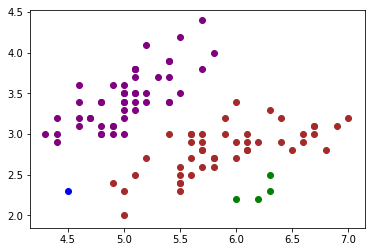

In [6]:
print('Case: Epsilon = {epsilon:.2f}, MinPoints = {minPoint}'.format(epsilon=eps, minPoint=minPoint))
db_scan = Clustering(epsilon = 0.33, minPoint = 2)
pointlabel,cluster = db_scan.fit(train)
print('Number of clusters: {cl}'.format(cl=cluster-1))
counter = collections.Counter(pointlabel)
print('Overall classes:')
print(counter)
outliers = pointlabel.count(0)
print('Number of outliers: {outliers}'.format(outliers=outliers))
db_scan.predict_plot(train, pointlabel, cluster)
plt.show()


Case: Epsilon = 0.30, MinPoints = 2
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 49, 0: 1})
Number of outliers: 1


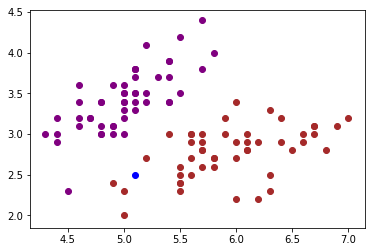



Case: Epsilon = 0.30, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 48, 0: 2})
Number of outliers: 2


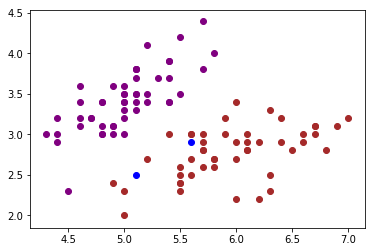



Case: Epsilon = 0.31, MinPoints = 2
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 49, 0: 1})
Number of outliers: 1


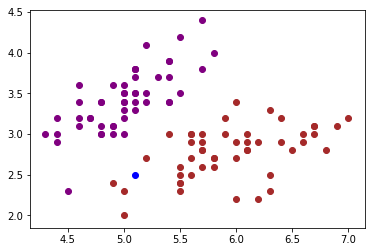



Case: Epsilon = 0.31, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 48, 0: 2})
Number of outliers: 2


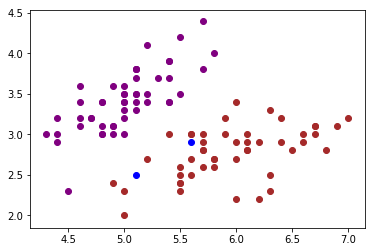



Case: Epsilon = 0.32, MinPoints = 2
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


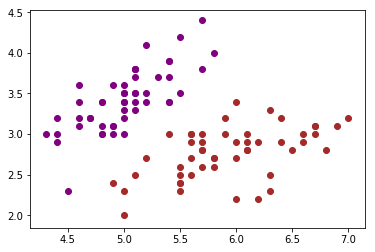



Case: Epsilon = 0.32, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


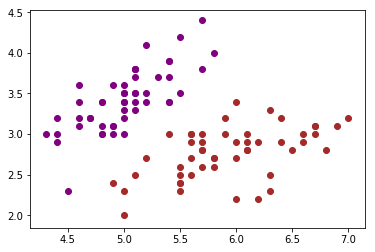



Case: Epsilon = 0.33, MinPoints = 2
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


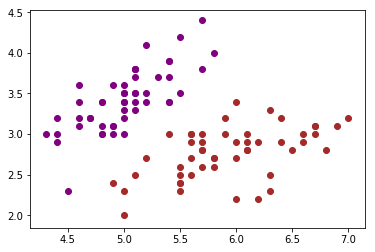



Case: Epsilon = 0.33, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


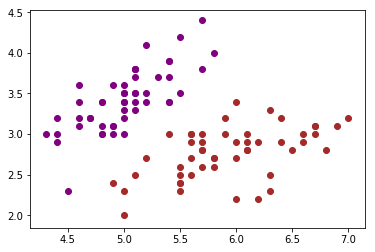



Case: Epsilon = 0.34, MinPoints = 2
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


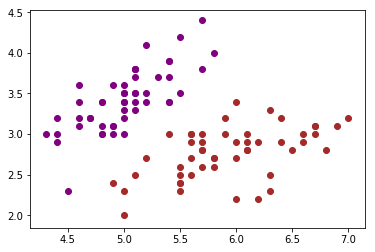



Case: Epsilon = 0.34, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


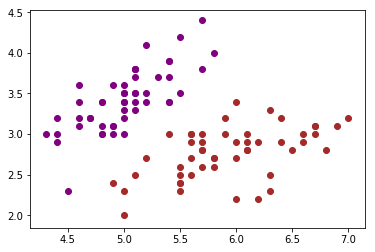



Case: Epsilon = 0.35, MinPoints = 2
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


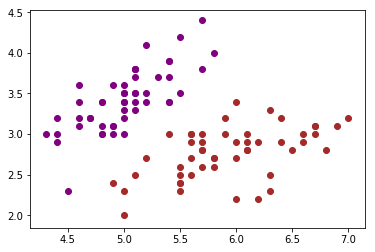



Case: Epsilon = 0.35, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


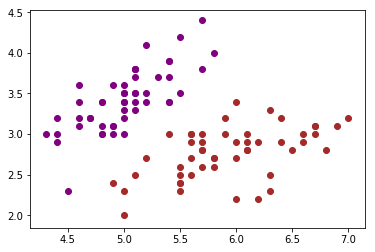



Case: Epsilon = 0.36, MinPoints = 2
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


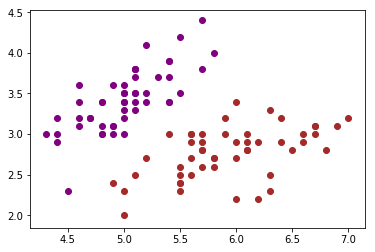



Case: Epsilon = 0.36, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


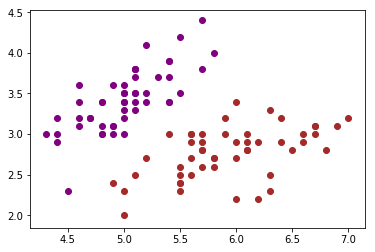



Case: Epsilon = 0.37, MinPoints = 2
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


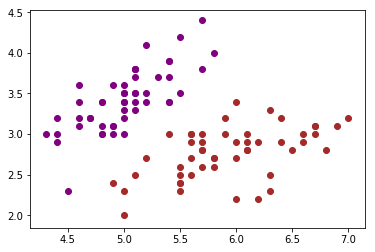



Case: Epsilon = 0.37, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


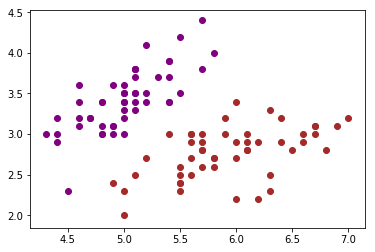



Case: Epsilon = 0.38, MinPoints = 2
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


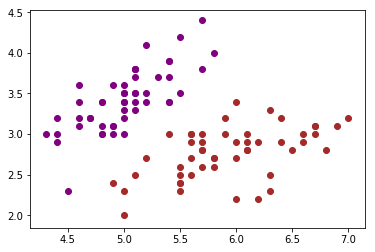



Case: Epsilon = 0.38, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


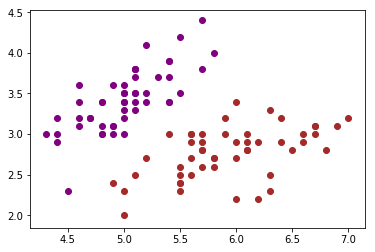



Case: Epsilon = 0.39, MinPoints = 2
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


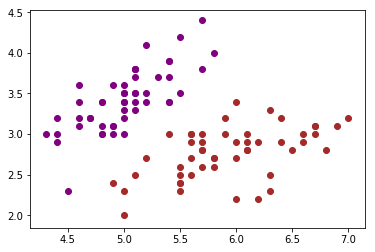



Case: Epsilon = 0.39, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


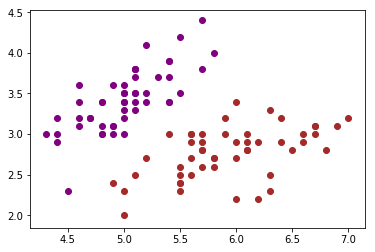



Case: Epsilon = 0.40, MinPoints = 2
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


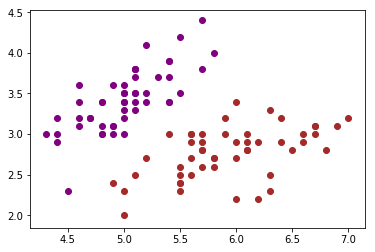



Case: Epsilon = 0.40, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


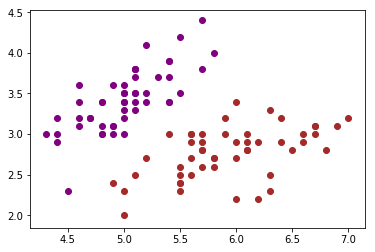

In [7]:
train2 = x_iris[:, 2:4]
epss = np.arange(0.3, 0.4, 0.01)
minPoints = np.arange(2,4)
for eps in epss:
    for minPoint in minPoints:
        print('Case: Epsilon = {epsilon:.2f}, MinPoints = {minPoint}'.format(epsilon=eps, minPoint=minPoint))
        db_scan = Clustering(epsilon = eps, minPoint = minPoint)
        pointlabel,cluster = db_scan.fit(train2)
        print('Number of clusters: {cl}'.format(cl=cluster-1))
        counter = collections.Counter(pointlabel)
        print('Overall classes:')
        print(counter)
        outliers = pointlabel.count(0)
        print('Number of outliers: {outliers}'.format(outliers=outliers))
        db_scan.predict_plot(train, pointlabel, cluster)
        plt.show()
        print('\n')

In [8]:
# The Algorithm Perfectly separates the data when
# Case: Epsilon = 0.32, MinPoints = 2
# Number of clusters: 2
# Overall classes:
# Counter({1: 50, 2: 50})
# Number of outliers: 0

Case: Epsilon = 0.40, MinPoints = 3
Number of clusters: 2
Overall classes:
Counter({1: 50, 2: 50})
Number of outliers: 0


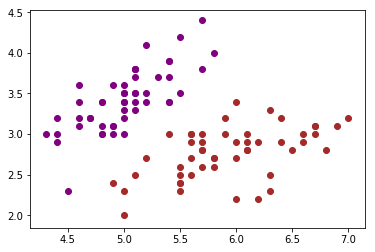

In [9]:
print('Case: Epsilon = {epsilon:.2f}, MinPoints = {minPoint}'.format(epsilon=eps, minPoint=minPoint))
db_scan = Clustering(epsilon = 0.32, minPoint = 2)
pointlabel,cluster = db_scan.fit(train2)
print('Number of clusters: {cl}'.format(cl=cluster-1))
counter = collections.Counter(pointlabel)
print('Overall classes:')
print(counter)
outliers = pointlabel.count(0)
print('Number of outliers: {outliers}'.format(outliers=outliers))
db_scan.predict_plot(train, pointlabel, cluster)
plt.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [10]:
db_scan = Clustering(epsilon = 0.33, minPoint = 2)
pointlabel,cluster = db_scan.fit(train)
pred_iris = np.array(pointlabel)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

db_scan = Clustering(epsilon = 0.32, minPoint = 2)
pointlabel,cluster = db_scan.fit(train2)
pred_iris1 = np.array(pointlabel)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris1))

Adjusted Rand index for iris is: 0.91
Adjusted Rand index for iris is: 1.00


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

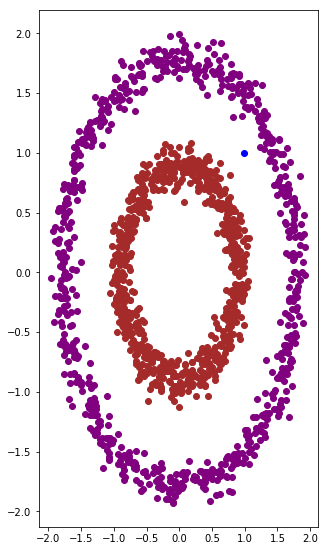

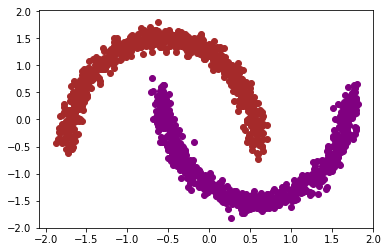

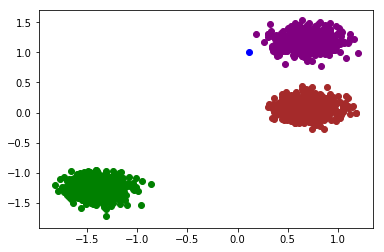

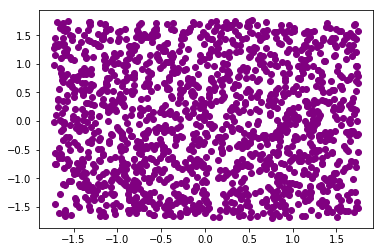

In [11]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]
X, y = data[2]
X = StandardScaler().fit_transform(X)


for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # plot
    db_scan = Clustering(epsilon = 0.2, minPoint = 2)
    pointlabel,cluster = db_scan.fit(X)
    db_scan.predict_plot(X, pointlabel, cluster)

    plt.show()